In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_closing, binary_opening


In [2]:


def generate_random_samples(n, rows=20, cols=20):
    """
    Generate n random dungeon layouts.

    Parameters:
    - n: Number of samples to generate
    - rows: Number of rows in the dungeon grid (default is 20)
    - cols: Number of columns in the dungeon grid (default is 20)

    Returns:
    - A NumPy array of size (n, rows, cols) representing random dungeon layouts.
    """
    samples = np.random.choice([0, 1], size=(n, rows, cols))
    return samples

# Example usage:
num_samples = 5
random_dungeons = generate_random_samples(num_samples)
print(random_dungeons.shape)  # Output: (5, 20, 20)

sample_dungeon = random_dungeons[0]


(5, 20, 20)


In [3]:
def print_dungeon(dungeon):
    """
    Convert the dungeon layout to a string representation.

    Parameters:
    - dungeon: NumPy array representing the dungeon layout.

    Returns:
    - A string representation of the dungeon layout with '#' for walls and '.' for empty spaces.
    """
    dungeon_str = '\n'.join([' '.join(['#' if cell == 1 else '.' for cell in row]) for row in dungeon])
    return dungeon_str

# Example usage:
for idx, dungeon in enumerate(random_dungeons):
    print(f"Sample {idx + 1}:\n{print_dungeon(dungeon)}\n")
    break


Sample 1:
. . # # # . . # # . . . # . # # . . . #
# . . # # . # # # # . # # . # # # . # .
. # # # # . # . . # . . # . . . . # # .
# # # . # . # . . . # . # . # . # . . .
# # # . . # . # # . # . . # # . # . . .
. . # . . . # # # . # # . . # # . # . .
. . . # # . . . . . . . # . . # . # # #
. # # # . # . . # # # # # . . # . . . .
. # . # # . # # # # # # . # . # . # . .
. . # . # . # . # # # # # # # # . . . #
# . . . # # # # # . . . # # . . # . # #
# # # . . . # # # . . . . # . # . . # .
# # # # . . . . # # # # # . . . # . # #
# . . # . . . # . # . . # # . . . . # .
# # . . # # . # # . # # # . . . . . . #
. . . # . . # # # . . # # # # . # . # .
# # # . # # . # . . # . . . . . . . . .
# . # # # . # # . . # . # . . # . . # .
# # . # # # . # . . # . . # # # . # # .
. . . . # . . # . # . # . # # . # # # #



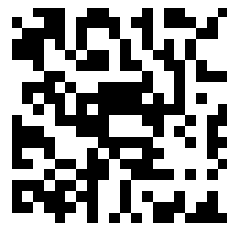

In [110]:
def plot_dungeon(dungeon):
    """
    Plot the dungeon using Matplotlib without axis labels.
    
    Parameters:
    - dungeon: NumPy array representing the dungeon layout.
    """
    fig, ax = plt.subplots()
    ax.imshow(dungeon, cmap='Greys')
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.axis('off')  # Turn off axis labels
    
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        spine.set_linewidth(2)
 
plot_dungeon(sample_dungeon)

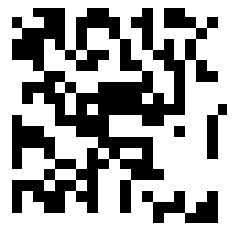

In [111]:
def apply_mutation1(dungeon, stride=1, window_size=2):
    """
    Apply mutation operation 1 to the dungeon array using a 2 by 2 convolutional operator.
    mutation operation 1 frees some space from the random noise.

    Parameters:
    - dungeon: NumPy array representing the original dungeon layout.

    Returns:
    - Updated NumPy array representing the modified dungeon layout.
    """
    updated_dungeon = np.zeros_like(dungeon)

    for i in range(0, dungeon.shape[0], stride):
        for j in range(0, dungeon.shape[1], stride):
            window_sum = np.sum(dungeon[i:i+window_size, j:j+window_size])

            # if only there is one wall there, remove it
            if window_sum == 1:
                updated_dungeon[i:i+window_size, j:j+window_size] = 0
            else:
                updated_dungeon[i:i+window_size, j:j+window_size] = dungeon[i:i+window_size, j:j+window_size]

    return updated_dungeon


# Apply mutation1 to the first dungeon layout
mutated1_dungeon = apply_mutation1(sample_dungeon)
plot_dungeon(mutated1_dungeon)


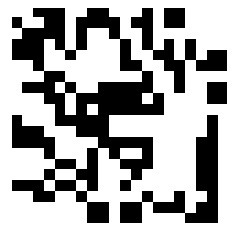

In [137]:
def apply_mutation2(dungeon, stride=3, window_size=5):
    """
    Apply mutation operation 2 to the dungeon array using a 6 by 6 convolutional operator.
    mutation operation 2 creates walls betweem large free spaces.

    Parameters:
    - dungeon: NumPy array representing the original dungeon layout.

    Returns:
    - Updated NumPy array representing the modified dungeon layout.
    """
    updated_dungeon = dungeon.copy()

    for i in range(0, dungeon.shape[0], stride):
        for j in range(0, dungeon.shape[1], stride):
            window_sum = np.sum(dungeon[i:i+window_size, j:j+window_size])

            # if its a big free space, randomply put walls on one of its sides
            if window_sum == 0:
             # Randomly choose one side (top, bottom, left, right)
                side = np.random.choice(['top', 'bottom', 'left', 'right'])

                if side == 'top' and i - 1 >= 0:
                    updated_dungeon[i-1:i+1, j:j+window_size] = 1
                elif side == 'bottom' and i + window_size < dungeon.shape[0]:
                    updated_dungeon[i+window_size-1:i+window_size+1, j:j+window_size] = 1
                elif side == 'left' and j - 1 >= 0:
                    updated_dungeon[i:i+window_size, j-1:j+1] = 1
                elif side == 'right' and j + window_size < dungeon.shape[1]:
                    updated_dungeon[i:i+window_size, j+window_size-1:j+window_size+1] = 1
                
    return updated_dungeon

mutated2_dungeon = apply_mutation2(apply_mutation1(apply_mutation1(mutated1_dungeon)))
plot_dungeon(mutated2_dungeon)

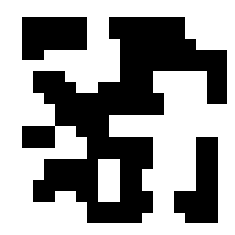

In [147]:
def apply_mutation3(dungeon, closing_size=2, opening_size=2):
    """
    Apply mutation operation 3 to the dungeon array using morphological closing and opening.

    Parameters:
    - dungeon: NumPy array representing the original dungeon layout.
    - closing_size: Size of the closing kernel (default is 3).
    - opening_size: Size of the opening kernel (default is 3).

    Returns:
    - Updated NumPy array representing the modified dungeon layout.
    """
    updated_dungeon = dungeon.copy()
    updated_dungeon = binary_closing(updated_dungeon, structure=np.ones((closing_size, closing_size)))
    updated_dungeon = binary_opening(updated_dungeon, structure=np.ones((opening_size, opening_size)))

    return updated_dungeon

mutated3_dungeon = apply_mutation3(mutated2_dungeon)
plot_dungeon(mutated3_dungeon)

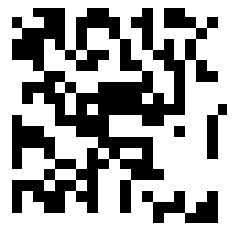

In [148]:
def update_dungeon(dungeon):
    """
    Update the dungeon array using mutation operations 1 and 2.

    Parameters:
    - dungeon: NumPy array representing the original dungeon layout.

    Returns:
    - Updated NumPy array representing the modified dungeon layout.
    """
    updated_dungeon = np.copy(dungeon)

    # Perform mutation 1 randomly 1 or 2 times
    mutation1_iterations = np.random.choice([1, 2])
    for _ in range(mutation1_iterations):
        updated_dungeon = apply_mutation1(updated_dungeon)

    # Perform mutation 2 once
    updated_dungeon = apply_mutation2(updated_dungeon)
    
    # Perform mutation 3 once
    # updated_dungeon = apply_mutation3(updated_dungeon)

    return updated_dungeon


# Update the first dungeon layout
updated_dungeon = update_dungeon(sample_dungeon)
plot_dungeon(updated_dungeon)


Iteration: 1
# . # # # . . # . # # . # # # . # . . #
. # . # . . # . # . . # . . . # # # . .
# # # . . # . . # # . # # # # . . # . #
. . # # . . # . # # . # . . . # . . . #
. # # # # . . . # # # . # . # # . . . #
. # # # . . # . . . # . . # # # # . # .
# # . . # . . # . . # . # . . . # . # #
. # . . . . # . . # . # # # . # # # # #
. . # # . . . # . . # # . # . # # . # .
. # # . # # . # . # . # . # # . # # # .
. # . # # # # . # . # # # # . # # . . #
. # . . . . # # # . # . . # . # # . # #
. . # # # . # . # # . . . # . . . # . .
. . . # . # # . . . # # . . . # . . # #
. . # # # # . . . # # # # . . # . . . #
. # # # # . . . . # # # . . . . # # # .
# . # . # . # # # . # # . . . . . . . .
. # # # # # # # . . . # . . . # . # . .
# # # . # # # # . . # # . # # . . . . #
# . # . . # . # . # . # # # # . # . . #
-------------------------

Iteration: 6
# . . . . . . # . # # . . . . . . # # .
. # . . . . . . # . . # . . . . . # # .
# . . . . . . . # # . # # # # . . # # .
. . . . . . . . # # . # . .

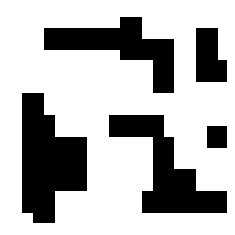

In [159]:
dungeon = generate_random_samples(1)[0]
for i in range(50):
    if i % 5 == 0:
        print("Iteration: {}". format(i+1))
        print(print_dungeon(dungeon))
        print("-"*25)
        print()
        
    dungeon = update_dungeon(dungeon)
plot_dungeon(apply_mutation3(dungeon))